# Vortex-source panel method

Philipp Schlatter, 2024
(adapted from Barba et al. Aeropython)

### Discretization into panels

Import necessary libraries and settings:

In [1]:
import os
import numpy as np
import math
from scipy import integrate, linalg
from matplotlib import pyplot as plt

# For Colab use inline
%matplotlib notebook
#%matplotlib inline

Load wing profile (e.g. NACA0012 or NACA4412). In order for the mapping to the cosine distribution works, we linearly extend the number of data points.

In [2]:
with open('naca4412.dat', 'r') as infile:
    x, y = np.loadtxt(infile, dtype=float, unpack=True)

In [3]:
# close the profile
x, y = np.append(x, x[0]), np.append(y, y[0])
# refine data set to avoid issues with the below matching algorithm
f=10   # add f points between each existing point
xx = yy= []
nn = x.size
for k in range(nn-1):
    x1,y1 = x[k],y[k]
    x2,y2 = x[k+1],y[k+1]
    for j in range(f):
        x3 = x1 + (j/f)*(x2-x1)
        y3 = y1 + (j/f)*(y2-y1)
        xx = np.append(xx,x3)
        yy = np.append(yy,y3)
xx, yy = np.append(xx, x[0]), np.append(yy, y[0])

<IPython.core.display.Javascript object>


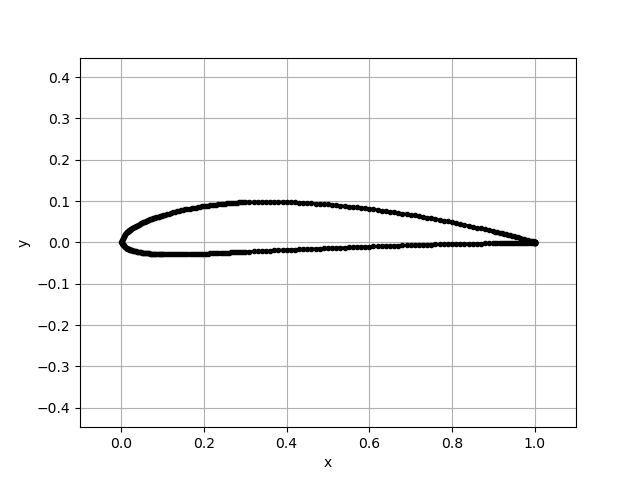

In [4]:
# plot geometry
plt.figure()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xx, yy, color='k', linestyle='-', linewidth=2, marker='.')
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

We use the following Panel class which stores relevant data for each panel.

In [5]:
class Panel:
    # Data for each panel
    def __init__(self, xa, ya, xb, yb):

        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

Let's discretise into $N$ panels:

In [6]:
def define_panels(x, y, N):
    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = np.linspace(0.0, 2.0 * np.pi, N + 1)  # array of angles
    x_circle = x_center + R * np.cos(theta)  # x-coordinates of circle
    
    x_ends = np.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = np.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface (already done above)
    # x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):

        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b

    y_ends[N] = y_ends[0]
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

In [25]:
# discretize geoemetry into panels
# (note that you need good resolution around the leading edge)
panels = define_panels(xx, yy, N=80)

<IPython.core.display.Javascript object>


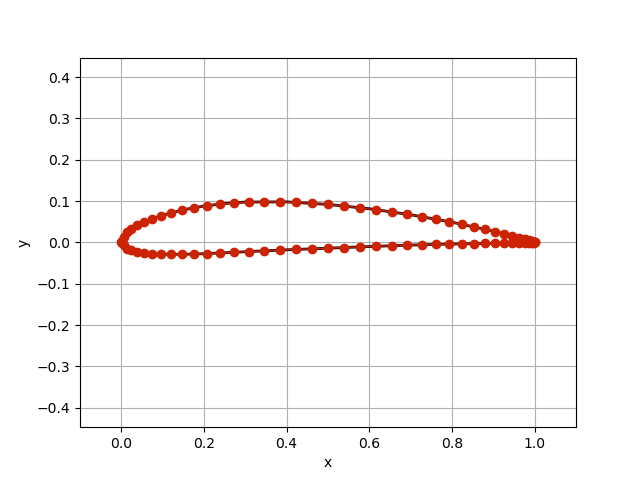

In [26]:
# plot discretized geometry
plt.figure()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

### Free stream conditions

Our free stream is used to define an angle of attack $\alpha$ for the profile.

In [27]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha_deg=0.0):
        self.u_inf = u_inf
        self.alpha_deg = alpha_deg
        self.alpha = np.radians(alpha_deg)  # convert angle to radians

In [43]:
freestream = Freestream(u_inf=1.0, alpha_deg=5)

### Flow tangency boundary condition

A constant vortex strength $\gamma$ will be added to each panel, proportional to its length. Using superposition, the velocity potential in point $(x_{c_i},y_{c_i})$ becomes the sum of the free-stream potential, the contributions of all panels due to their sources and due to the vortices:

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

The flow tangency boundary condition is applied at every panel center:

$$0 = \vec{V}\cdot\vec{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

i.e.

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

We can now work on the various terms:

$$\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$ is the slope of each panel, and thus the coordinates along each panel are given as

$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$

$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$

We now need to derive the last integral of the boundary equation:

$$\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$ as above.

### Enforcing the Kutta condition

To enforce the *Kutta-condition*, we assume that there is no pressure difference at the trailing edge, i.e. the velocity does not flow around the trailing edge. Thus, for the discretisation in panels we have, we state that the pressure coefficient on the first panel must be equal to that on the last panel:

$$C_{p_1} = C_{p_{N}}$$

Using the definition of the pressure coefficient $C_p = 1-\left(\frac{V}{U_\infty}\right)^2$, the Kutta-condition implies that the magnitude of the velocity at the first panel center must equal the magnitude of the last panel center:

$$V_1^2 = V_N^2$$

Since the flow tangency condition requires that $V_{n_1} = V_{n_N} = 0$, we end up with the following *Kutta-condition*:

$$V_{t_1} = - V_{t_N}$$

(the minus sign comes from the reference axis we chose for the normal and tangential vectors), i.e. that the flow in the horizontal direction in the two panels at the trailing edge are the same. This is an approximation, and means that we should only consider sharp trailing edges.


Let's derive the tangential velocity for every panel, since it will be useful to compute the pressure coefficient, as the tangential derivative of the velocity potential,

$$V_{t_i} = \frac{\partial}{\partial t_i} \left(\phi\left(x_{c_i},y_{c_i}\right)\right)$$

i.e.,

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial t_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial t_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$


which gives

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$

where $\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i$ and $\frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$.

### Building the linear system

Here, we build and solve the linear system of equations of the form

$$[A][\sigma,\gamma] = [b]$$

where the $N+1 \times N+1$ matrix $[A]$ contains three blocks: an $N \times N$ source matrix (the same one of Lesson 10), an $N \times 1$ vortex array to store the weight of the variable $\gamma$ at each panel, and a $1 \times N+1$ Kutta array that repesents our Kutta-condition.

We are going to define a function `integral` to evaluate the different integrals with the SciPy function `integrate.quad`, which is using a quadrature rule:

In [44]:
def integral(x, y, panel, dxdk, dydk):
    # evaluate the influence of sources/vortices of a panel in a points (x,y)
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

We first define the function `source_contribution_normal` to build the source matrix, i.e. the weight from each source on the normal velocity of each panel:

In [45]:
def source_contribution_normal(panels):
    # Builds the source contribution matrix for the normal velocity.

    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.cos(panel_i.beta),
                                                 np.sin(panel_i.beta))
    return A

Then, we define `vortex_contribution_normal` to build the vortex matrix:

In [46]:
def vortex_contribution_normal(panels):
    # Builds the vortex contribution matrix for the normal velocity.

    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

Let's call both of these functions to create the source matrix `A_source` and the vortex matrix `B_vortex`:

In [47]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

Now we need to get the last row for our system of equations corresponding to the Kutta condition. As one can infer from the above derivation, the contributions of the vortices and sources on the normal and tangential velocity are exactly opposite. 
Thus, the Kutta condition can be cast in the following form

$$
\begin{bmatrix}
(A^t_{11}+A^t_{N1}) \\
\vdots \\ 
(A^t_{1N}+A^t_{NN}) \\
\left( \sum_{j=1}^N (B^t_{1j}+B^t_{Nj}) \right)
\end{bmatrix}^T
\begin{bmatrix}
\sigma_1 \\
\vdots \\
\sigma_N \\
\gamma
\end{bmatrix} = -(b^t_1+b^t_N)
$$

Let's define a function `kutta_condition` that does the job:

In [48]:
def kutta_condition(A_source, B_vortex):

    b = np.empty(A_source.shape[0] + 1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

We now have all the ingredients we need.  The function `build_singularity_matrix` will gather together the source matrix, the vortex array, and the Kutta array to build the matrix needed to solve the linear system. 

In [49]:
def build_singularity_matrix(A_source, B_vortex):

    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

On the right-hand side, we store everything that does not depend on the unknown strengths.

In [50]:
def build_freestream_rhs(panels, freestream):

    b = np.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta) )
    return b

In [51]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

Now we solve the linear system using the Scipy function `linalg.solve`. Then we store the results in the attribute `sigma` of each `Panel` object. We also create a variable `gamma` to store the value of the constant vortex strength.

In [52]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

### Surface pressure coefficient

The pressure coefficient at the $i$-th panel center is (on the wing's surface)

$$C_{p_i} = 1 - \left(\frac{V_{t_i}}{U_\infty}\right)^2$$

So, we have to compute the tangential velocity at each panel center using the function `compute_tangential_velocity`:

In [53]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):

    A = np.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [54]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

And we define a function `compute_pressure_coefficient` to compute the surface pressure coefficient:

In [55]:
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [56]:
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

### Plotting of the results

<IPython.core.display.Javascript object>


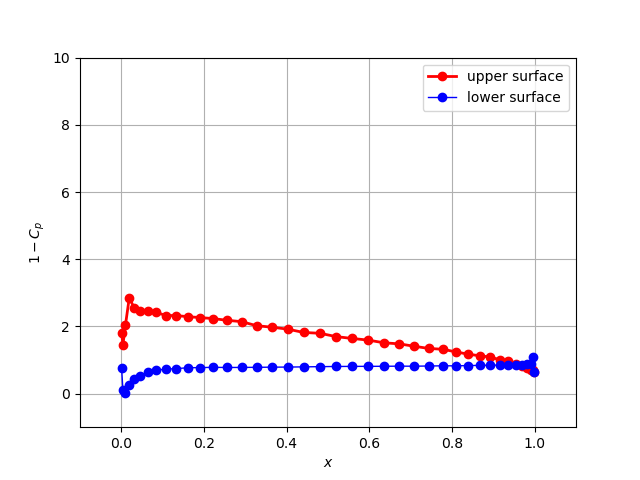

In [57]:
# plot surface pressure coefficient
plt.figure()
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$1-C_p$')
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [1-panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [1-panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.legend(loc='best')
plt.xlim(-0.1, 1.1)
plt.ylim(-1.0, 10.0)
plt.show()

<IPython.core.display.Javascript object>


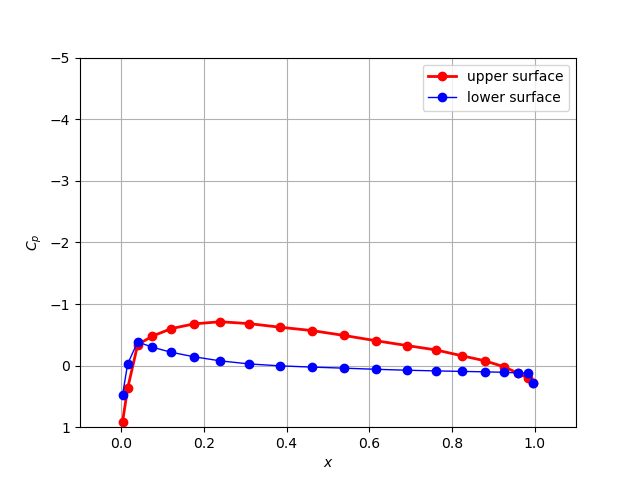

In [119]:
# plot surface pressure coefficient
plt.figure()
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$C_p$')
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.legend(loc='best')
plt.xlim(-0.1, 1.1)
plt.ylim(1, -5.0)
plt.show()

### Accuracy check

For a closed body, the sum of all the source strengths must be zero. If not, it means the body would be adding or absorbing mass from the flow! Therefore, we should have

$$\sum_{i=1}^{N} \sigma_i l_i = 0$$

where $l_i$ is the length of the $i^{\text{th}}$ panel.

With this, we can get a measure of the accuracy of the source panel method.

In [120]:
# calculate the accuracy
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.003879


### Lift coefficient

The lift  is given by the Kutta-Joukowski theorem, $L = \rho \Gamma U_\infty$, 
where $\rho$ is the fluid density. The total circulation $\Gamma$ is given by:

$$\Gamma = \sum_{i=1}^N \gamma l_i=\gamma \sum_{i=1}^N l_i$$

Finally, the lift coefficient is given by:

$$c_l = \frac{\sum_{i=1}^N \gamma l_i}{\frac{1}{2}U_\infty c}= \frac{\Gamma}{\frac{1}{2}U_\infty c}$$

with $c$ the chord-length of the airfoil.

In [121]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
alpha0 = -3.5*np.pi/180
print('lift coefficient: CL = {:0.3f}'.format(cl))
print('    chord length: c  = {:0.3f}'.format(c))
print('     theoretical: CL = {:0.5f}'.format(2*np.pi*(freestream.alpha-alpha0 )))

lift coefficient: CL = 0.421
    chord length: c  = 1.000
     theoretical: CL = 0.38382


To be done: Integration of the pressure forces using surface integration.

In [ ]:
### Computation of the velocity fields

In [141]:
def get_velocity_field(panels, freestream, X, Y):

    # freestream contribution
    u = freestream.u_inf * np.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * np.sin(freestream.alpha) * np.ones_like(X, dtype=float)

    # add the contribution from each source (superposition powers!!!)
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)

    # add the contribution of the vortex
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += gamma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
        v += gamma / (2.0 * np.pi) * vec_intregral(X, Y, panel, -1.0, 0.0)
    
    return u, v

In [142]:
# define a Cartesian grid
nx, ny = 50, 50  # number of points in the x and y directions-
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.5, 0.5
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                      np.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

<IPython.core.display.Javascript object>


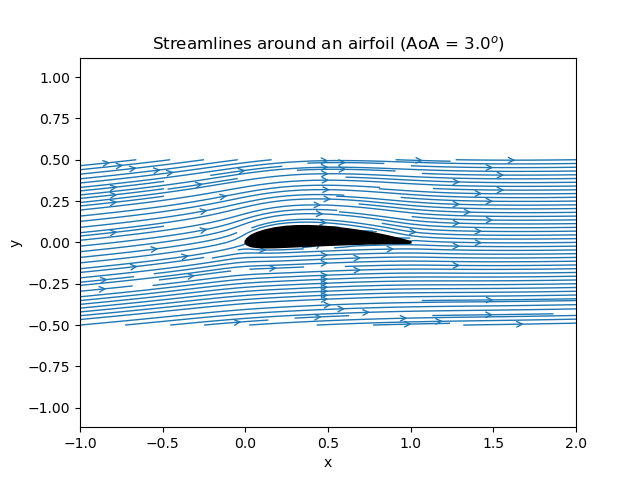

In [143]:
# plot the velocity field
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.streamplot(X, Y, u, v, density=1.5, linewidth=1, arrowsize=1, arrowstyle='->')
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('equal')
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.title('Streamlines around an airfoil (AoA = ${}^o$)'.format(freestream.alpha*180/np.pi));

<IPython.core.display.Javascript object>


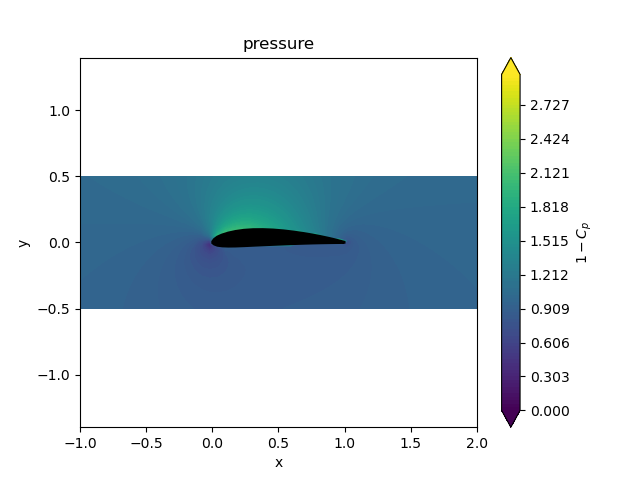

In [144]:
# compute the pressure field
cp = 1.0 - (u**2 + v**2) / freestream.u_inf**2

# plot the pressure field
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
contf = plt.contourf(X, Y, 1-cp,
                        levels=np.linspace(0, 3, 100), extend='both')
cbar = plt.colorbar()
cbar.set_label('$1-C_p$')
#plt.contour(X,Y,1-cp,[2],colors='r')
#plt.contour(X,Y,1-cp,[0.5],colors='r')
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('equal')
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.title('pressure');